**Pepper Disease Classification**

Dataset- https://www.kaggle.com/arjuntejaswi/plant-village

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3

In [4]:
#importing dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Datasets/PlantVillage/PepperBell",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2475 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

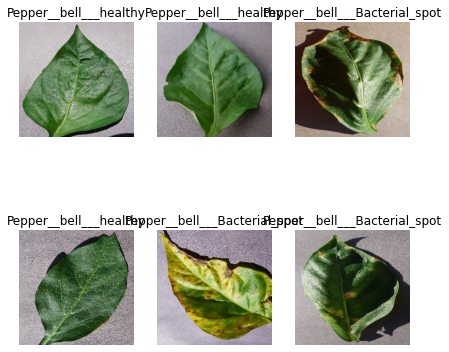

In [6]:
plt.figure(figsize=(7, 7))
for image_batch, labels_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
#divinding dataset into training, validation and test partition 
def get_train_val_test_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_train_val_test_tf(dataset)

In [9]:
#applying caching, shuffling and prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [51]:
#resizing and normlizing
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [52]:
#data augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [91]:
#building the model
n_classes = 2
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [92]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (32, 62, 62, 64)          0         
_________________________________________________________________
flatten_16 (Flatten)         (32, 246016)            

In [93]:
#compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [94]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
62/62 [==============================] - 4s 57ms/step - loss: 0.6458 - accuracy: 0.7687 - val_loss: 0.5275 - val_accuracy: 0.8750
Epoch 2/10
62/62 [==============================] - 3s 54ms/step - loss: 0.2444 - accuracy: 0.9027 - val_loss: 0.6433 - val_accuracy: 0.9286
Epoch 3/10
62/62 [==============================] - 3s 55ms/step - loss: 0.1695 - accuracy: 0.9379 - val_loss: 1.0789 - val_accuracy: 0.8795
Epoch 4/10
62/62 [==============================] - 3s 54ms/step - loss: 0.1605 - accuracy: 0.9404 - val_loss: 1.0595 - val_accuracy: 0.9286
Epoch 5/10
62/62 [==============================] - 3s 54ms/step - loss: 0.1574 - accuracy: 0.9429 - val_loss: 1.4425 - val_accuracy: 0.8750
Epoch 6/10
62/62 [==============================] - 3s 54ms/step - loss: 0.1372 - accuracy: 0.9567 - val_loss: 1.3932 - val_accuracy: 0.9375
Epoch 7/10
62/62 [==============================] - 3s 55ms/step - loss: 0.1470 - accuracy: 0.9542 - val_loss: 1.4885 - val_accuracy: 0.9286
Epoch 8/10
62

In [95]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 0s 20ms/step - loss: 0.0845 - accuracy: 0.9722


In [96]:
scores

[0.08453970402479172, 0.9722222089767456]

**Got 97% accuracy on test datase**

In [97]:
EPOCHS=len(history.history['loss'])

In [98]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

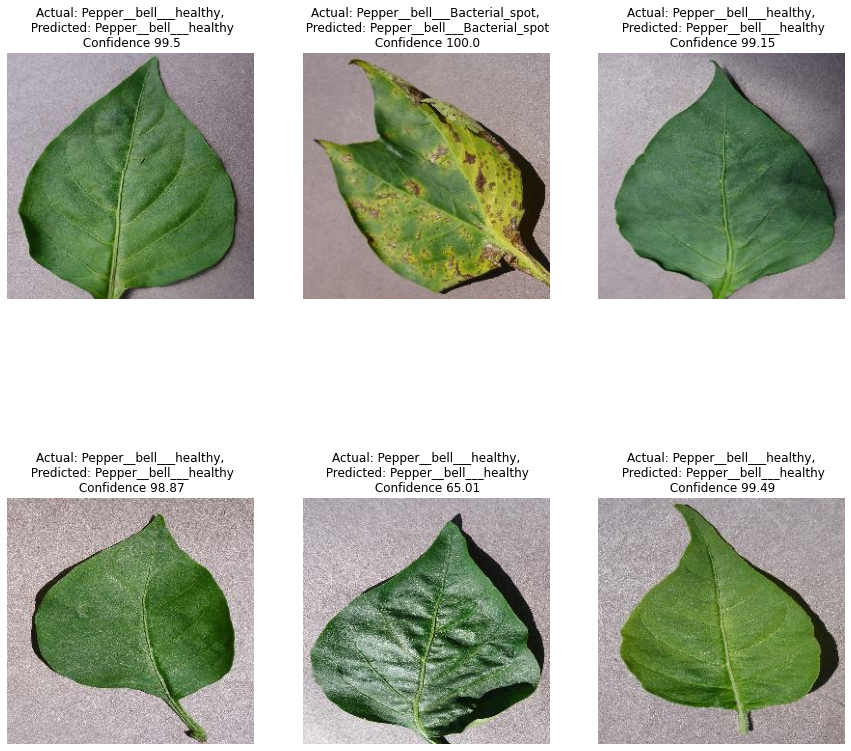

In [100]:
import numpy as np
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}\n Confidence {confidence}")
        
        plt.axis("off")

In [101]:
#saving the model
import os
model.save("../models/pepperbell_disease_classifier.h5")

INFO:tensorflow:Assets written to: pepperbell_disease_classifier/assets
